# Baseline Solution

In [2]:
from copy import deepcopy
from pathlib import Path
from dataclasses import dataclass

import pickle 
import numpy as np
import numpy.typing as npt
import networkx as nx 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

DATA_DIR = Path().absolute().parent / "data"

## Reading functions

In [3]:
@dataclass
class ROI:
    start_x: float
    start_y: float
    end_x: float
    end_y: float

In [80]:
@dataclass
class CoronagraphyScanItem:
    name: str
    scan: npt.NDArray[np.uint8]
    vessel_mask: npt.NDArray[bool]
    centerline: nx.Graph
    rois: list[ROI]
    
    def plot(self, roi_im: str = "seg"):
        fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
    
        axes[0].imshow(self.scan, cmap='gray')
        axes[1].imshow(self.vessel_mask, cmap='gray')

        nodes = np.array(self.centerline.nodes)
        axes[1].scatter(nodes[:, 1], nodes[:, 0], s=10, c='blue')
        
        for (x1, y1), (x2, y2) in self.centerline.edges:
            axes[1].plot([y1, y2], [x1, x2], c='pink')
            
        for roi in self.rois:
            rect = patches.Rectangle(
                (roi.start_x, roi.start_y), roi.end_x - roi.start_x, roi.end_y - roi.start_y,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            axes[1 if roi_im == "seg" else 0].add_patch(rect)
        
        plt.show()

In [81]:
def read_dataset(dataset_dir: str):
    dataset_dir = Path(dataset_dir)
    
    items = []
    for item_dir in dataset_dir.iterdir():
        if not item_dir.is_dir() and not item_dir.name.startswith('seg'):
            continue
        
        # scan
        with open(item_dir / 'representative_frame.p', 'rb') as f:
            scan = pickle.load(f)
        
        # centerline
        with open(item_dir / 'centreline.p', 'rb') as f:
            centerline = pickle.load(f)
            
        # vessel mask
        mask_img = Image.open(item_dir / 'segmentation.png')
        mask = np.array(mask_img)[:, :, 0] == 253
        
        # roi
        with open(item_dir / 'roi.p', 'rb') as f:
            roi_list = pickle.load(f)
        
        rois = []
        for d in roi_list:
            roi = ROI(d['start']['x'], d['start']['y'], d['end']['x'], d['end']['y'])
            rois.append(roi)
        
        # adding
        item = CoronagraphyScanItem(
            item_dir.name,
            scan,
            mask,
            centerline,
            rois
        )
        items.append(item)
    return items

In [82]:
dataset = read_dataset(DATA_DIR)

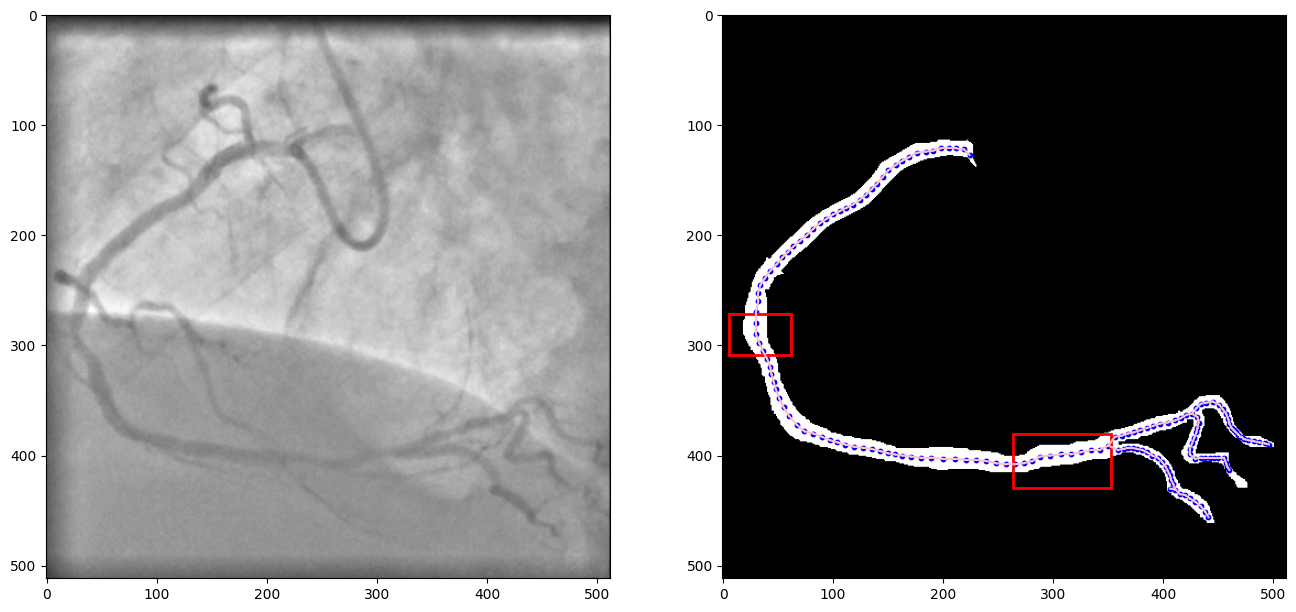

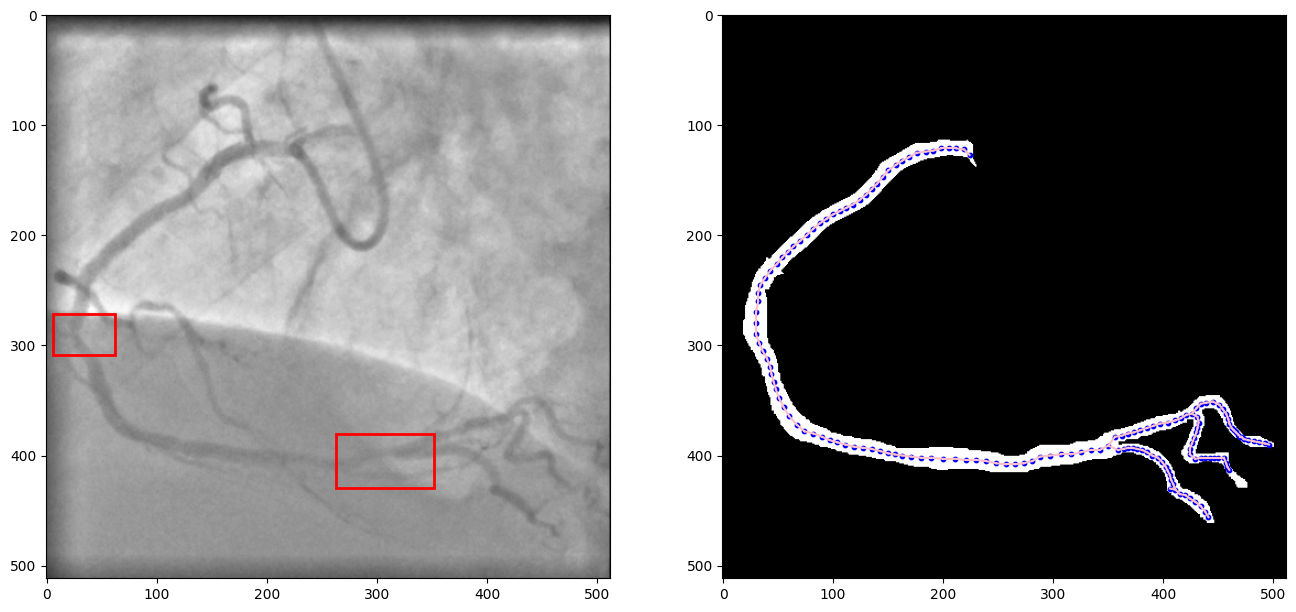

'seg50'

In [106]:
item = dataset[5]
item.plot("seg")
item.plot("scan")
item.name

Problems with segmentation showed below!

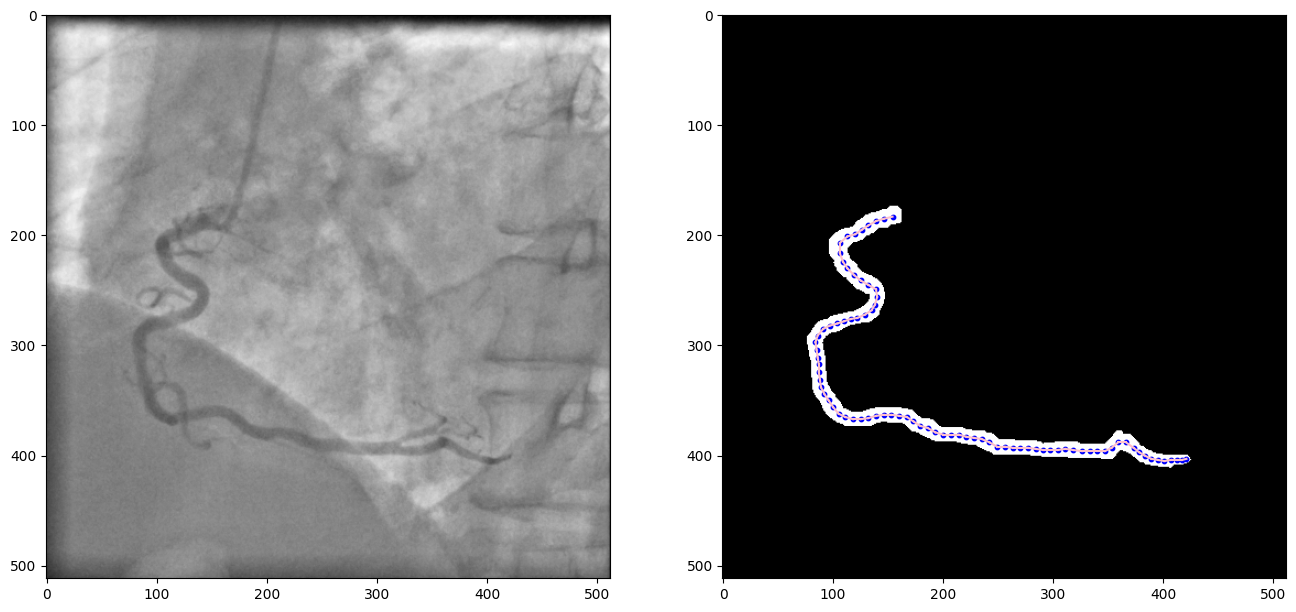

In [42]:
dataset[28].plot()

## Baseline

In [87]:
from itertools import combinations
from typing import Any, Iterator

In [88]:
def interpolate_matrix(matrix: npt.NDArray[np.float32], i: float, j: float) -> float:
    if not (0 <= i < matrix.shape[0]-1 and 0 <= j < matrix.shape[1]-1):
        return 0.0
#         raise ValueError('invalid indexing')
        
    upper = int(i)
    left = int(j)
    lower = upper + 1
    right = left + 1
    
    ul = matrix[upper, left]
    ll = matrix[lower, left]
    ur = matrix[upper, right]
    lr = matrix[lower, right]
    
    left_vertical_interpolation  = ul * (lower - i) + ll * (i - upper)
    right_vertical_interpolation = ur * (lower - i) + lr * (i - upper)
    
    interpolation = left_vertical_interpolation * (right - j) + right_vertical_interpolation * (j - left)
    return interpolation

In [89]:
@dataclass
class VesselBranch:
    item: CoronagraphyScanItem
    branch: nx.Graph
        
    def boundary_nodes(self) -> tuple[Any, Any]:
        boundary_nodes = [node for node in self.branch.nodes if len(self.branch[node]) == 1]
        return sorted(boundary_nodes)
        
    def traverse_branch_nodes(self) -> list[Any]:
        start_node, end_node = self.boundary_nodes()
        
        return list(nx.dfs_preorder_nodes(self.branch, source=start_node))
    
    def traverse_branch_edges(self) -> list[tuple[Any, Any]]:
        nodes = self.traverse_branch_nodes()
        return list(zip(nodes[:-1], nodes[1:]))
    
    def plot(self):
        item_copy = deepcopy(self.item)
        item_copy.centerline = self.branch
        item_copy.plot()

In [90]:
def split_into_branches(item: CoronagraphyScanItem) -> list[VesselBranch]:
    branches = []
    branching_nodes = []
    
    G: nx.Graph = item.centerline.copy()
    for node in G.nodes:
        if len(G[node]) >= 3:
            branching_nodes.append(node)
    
    G.remove_nodes_from(branching_nodes)
    
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component).copy()
        branches.append(subgraph)
        
        # adding the branching nodes to each branch, if they were connected
        for branching_node in branching_nodes:
            for bn_neighbor in item.centerline[branching_node]:
                if bn_neighbor in component:
                    subgraph.add_edge(branching_node, bn_neighbor)
    
    return [VesselBranch(item, branch) for branch in branches]

In [91]:
branches = split_into_branches(item)

In [107]:
item = dataset[5]
branches = split_into_branches(item)

In [110]:
branches[0].branch.nodes

NodeView(((403, 200), (403, 211), (402, 189), (402, 180), (401, 171), (400, 163), (399, 156), (398, 150), (396, 143), (394, 135), (393, 127), (392, 119), (390, 111), (388, 104), (386, 97), (383, 90), (380, 82), (378, 74), (372, 67), (364, 60), (356, 55), (348, 51), (340, 48), (333, 46), (326, 44), (320, 43), (312, 40), (305, 36), (298, 33), (290, 30), (280, 30), (270, 30), (260, 32), (252, 32), (245, 34), (239, 38), (232, 43), (226, 49), (220, 54), (215, 59), (210, 64), (205, 70), (200, 76), (194, 82), (189, 88), (185, 94), (181, 100), (178, 106), (175, 112), (172, 118), (168, 124), (163, 130), (158, 135), (153, 140), (147, 145), (141, 150), (136, 157), (132, 163), (129, 169), (125, 176), (124, 184), (123, 191), (121, 198), (121, 205), (121, 212), (122, 219), (127, 224), (404, 221), (404, 230), (405, 239), (407, 248), (408, 257), (408, 265), (407, 273), (405, 281), (401, 288), (400, 297), (399, 307), (399, 316), (397, 325), (395, 334), (395, 342), (391, 350)))

In [ ]:
plot_analysis(item)

### Algorithm (sweeping along the centerline)

In [92]:
def width_sweep(branch: VesselBranch, sampling_rate: int = 4) -> npt.NDArray[np.float32]:
        
    def get_orthonormal_vector_2d(v: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        ov = np.array([v[1], -v[0]], dtype=v.dtype)
        return ov / np.linalg.norm(ov)

    def width_along_vector(anchor: npt.NDArray[np.float32], unit_vector: npt.NDArray[np.float32]) -> np.float32:
        width = 0.0

        # going forward
        pos = np.copy(anchor)
        while True:
            pos += unit_vector
            value = interpolate_matrix(branch.item.vessel_mask, pos[0], pos[1])
            if np.isclose(value, 0):
                break

            width += value

        # going backward
        pos = np.copy(anchor)
        while True:
            pos -= unit_vector
            value = interpolate_matrix(branch.item.vessel_mask, pos[0], pos[1])
            if np.isclose(value, 0):
                break

            width += value

        return width


    widths = []
    for v, w in branch.traverse_branch_edges():
        v = np.array(v, dtype=np.float32)
        w = np.array(w, dtype=np.float32)
        vessel_direction = w - v  # TODO we could normalize this and omit `sampling_rate`
        orthonormal_vector = get_orthonormal_vector_2d(vessel_direction)

        for i in range(sampling_rate):
            anchor = v + (vessel_direction * i) / sampling_rate
            width = width_along_vector(anchor, orthonormal_vector)
            widths.append(width)

    return np.array(widths)

In [93]:
# TODO develop this for the better analysis
def plot_widths(widths: npt.NDArray[np.float32]):
    plt.figure(figsize=(16, 4))
    
    xs = np.arange(widths.shape[0])
    plt.plot(xs, widths)
    plt.plot([xs[0], xs[-1]], [np.mean(widths), np.mean(widths)], c='yellow')
    plt.show()

In [94]:
# TODO develop this for the better analysis
def plot_analysis(item: CoronagraphyScanItem):
    branches = split_into_branches(item)
    for branch in branches:
        widths = width_sweep(branch, sampling_rate=15)
        plot_widths(widths)
        branch.plot()

## TODO How to plot the region of interest on the widths series? If we have ROI on the series we could TRY to classify

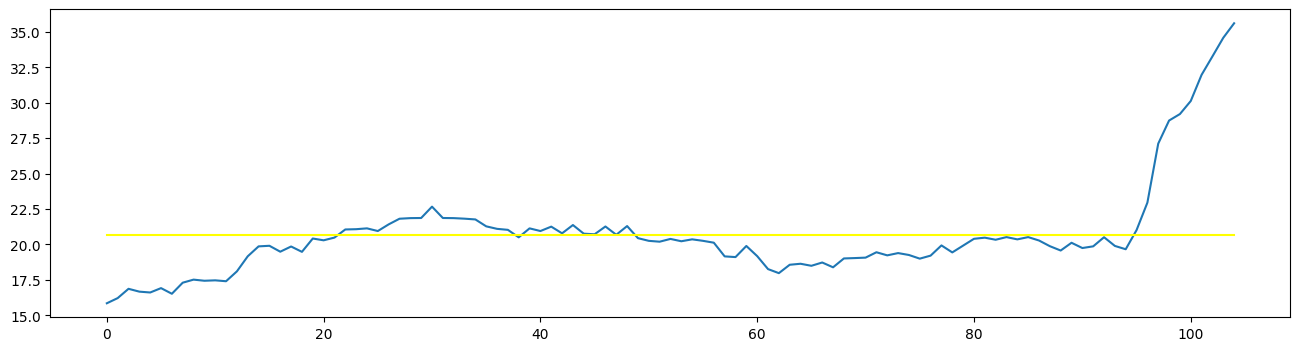

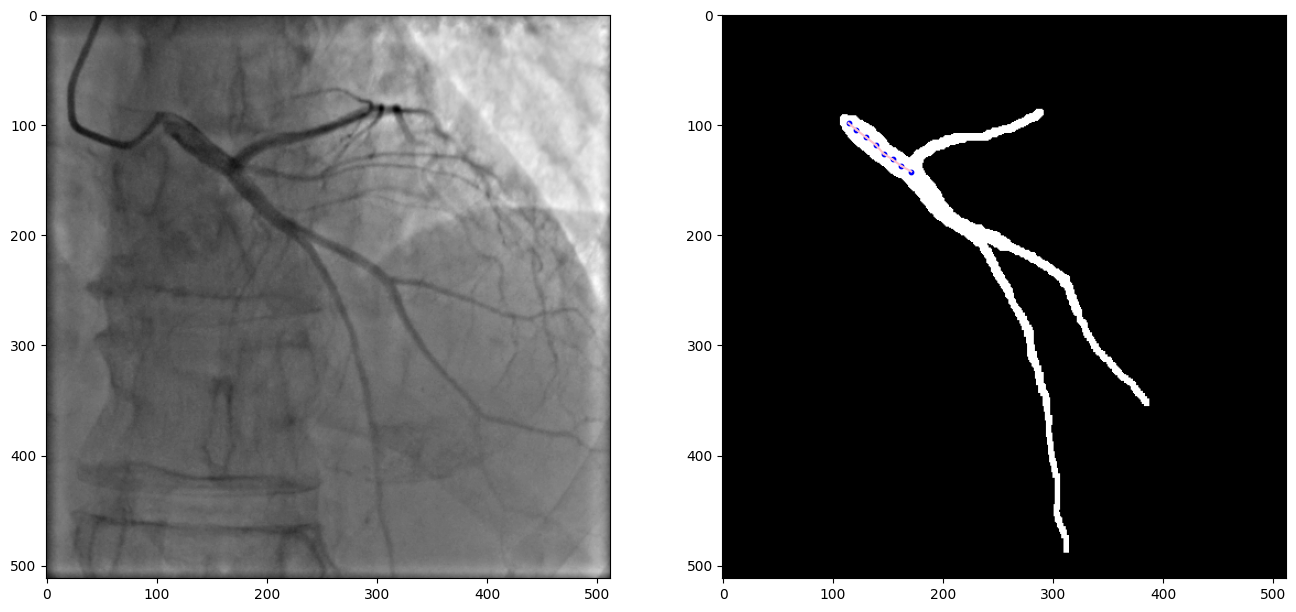

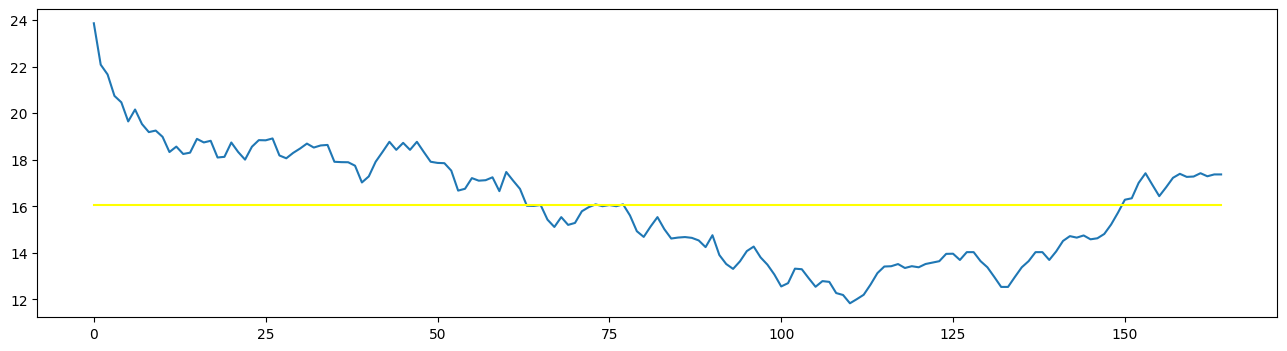

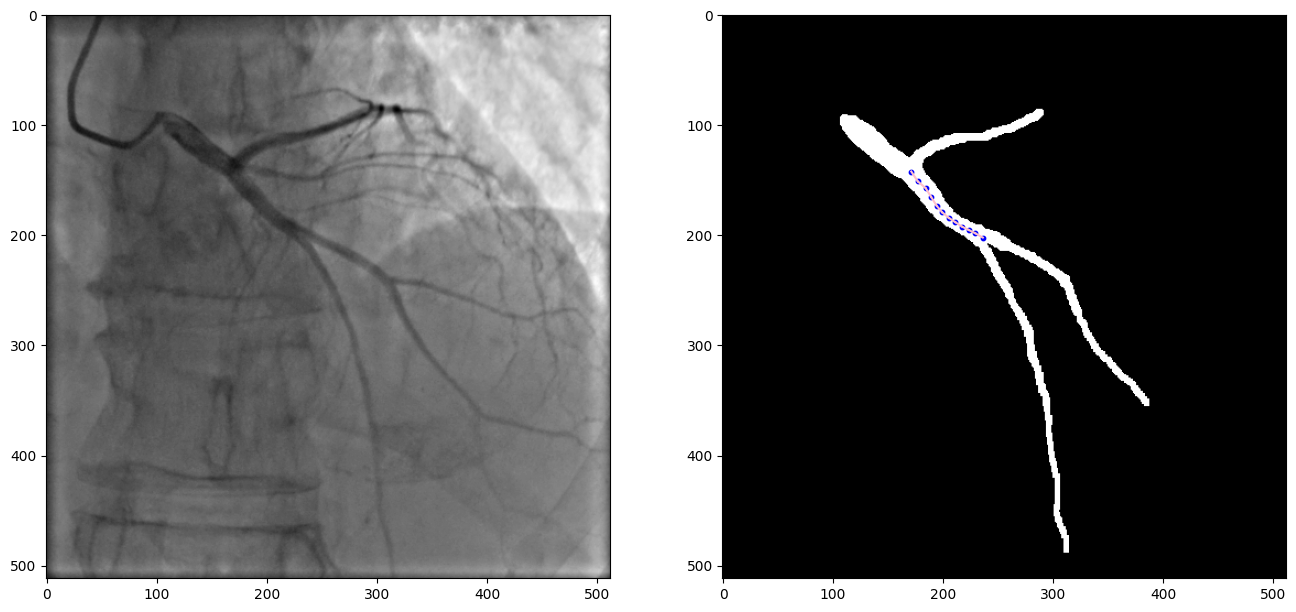

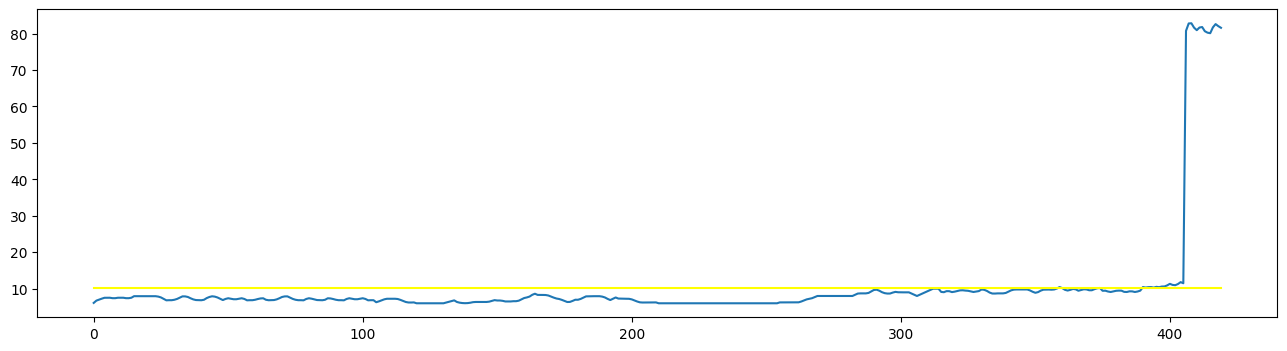

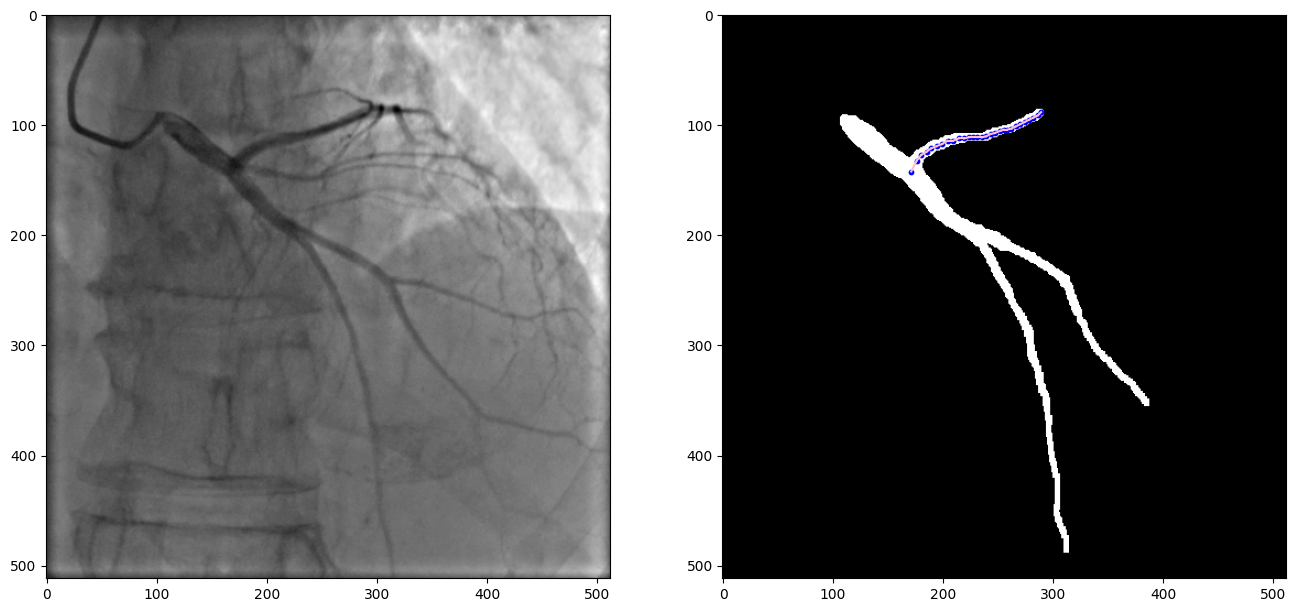

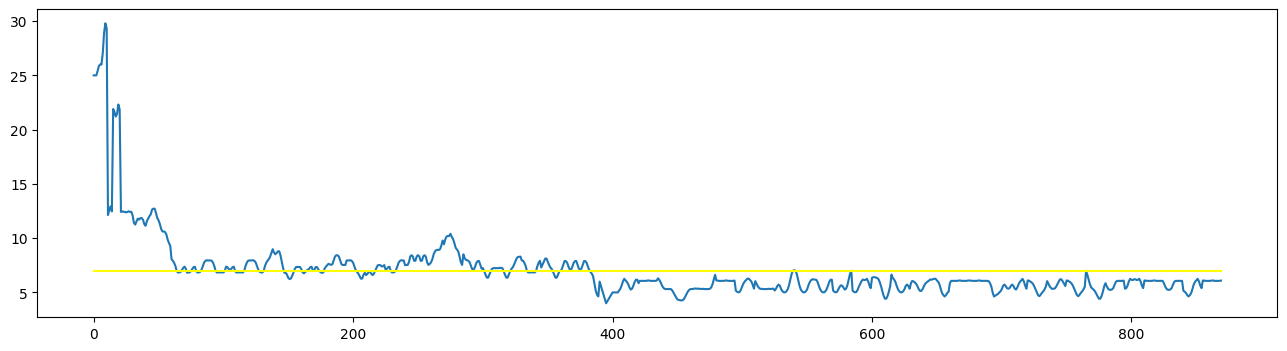

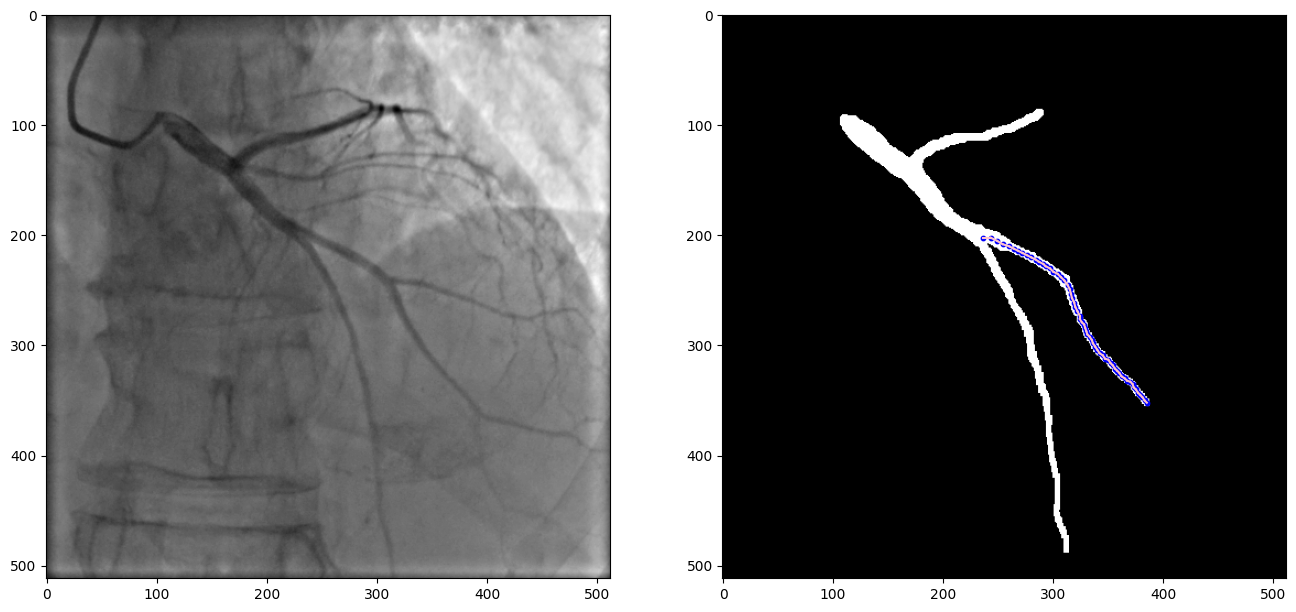

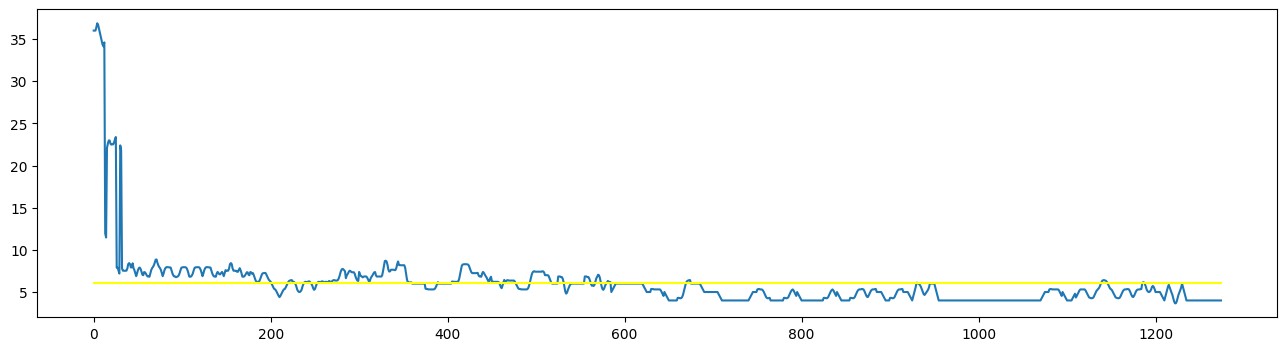

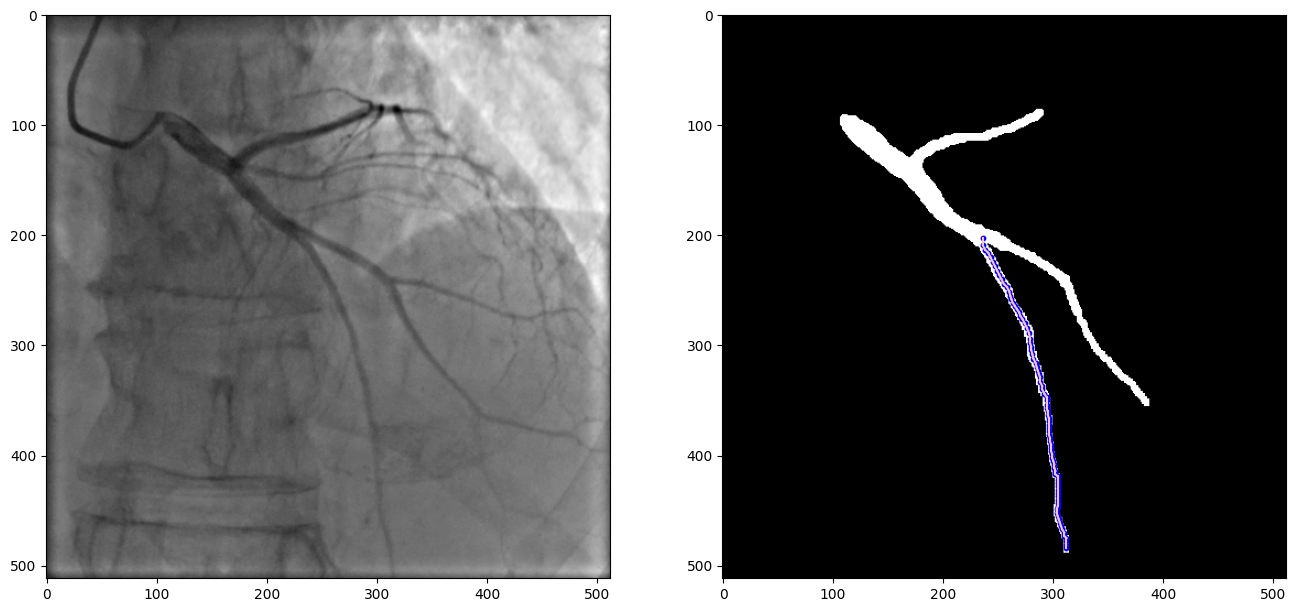

In [202]:
plot_analysis(item)

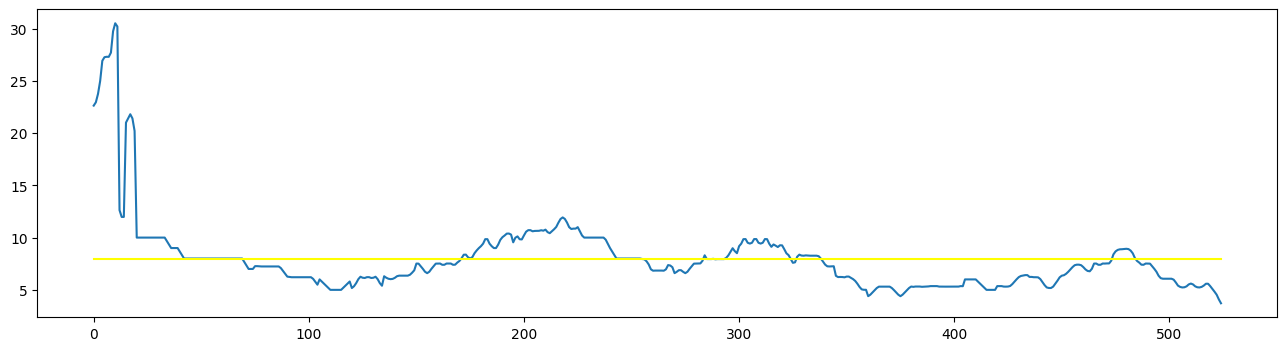

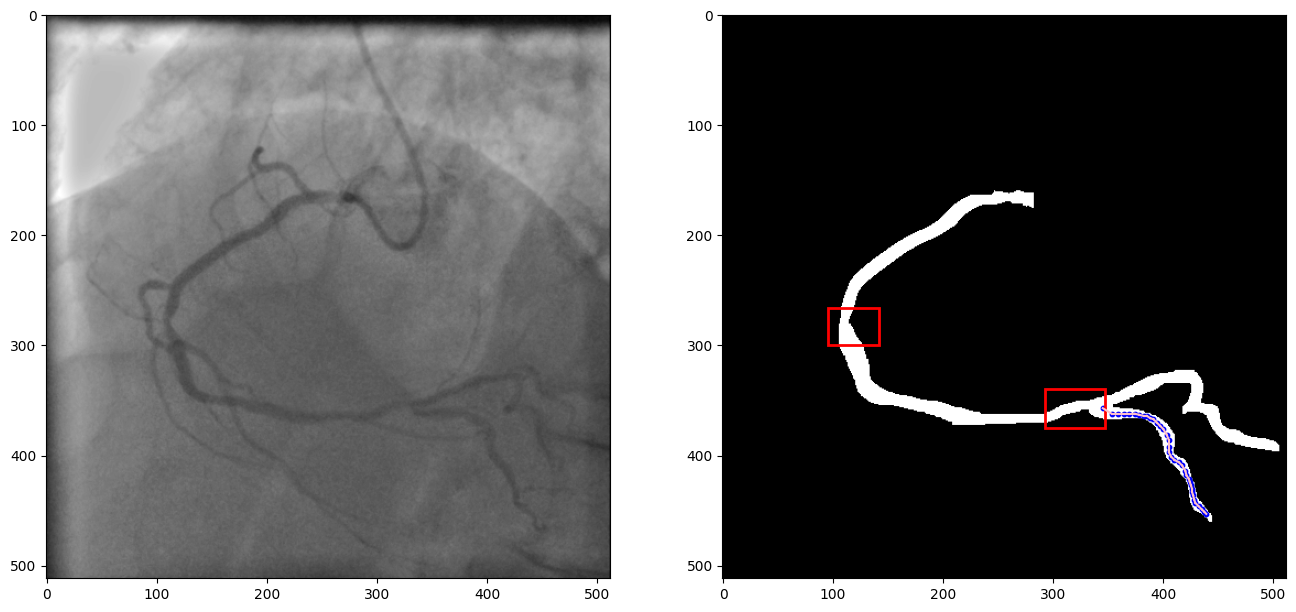

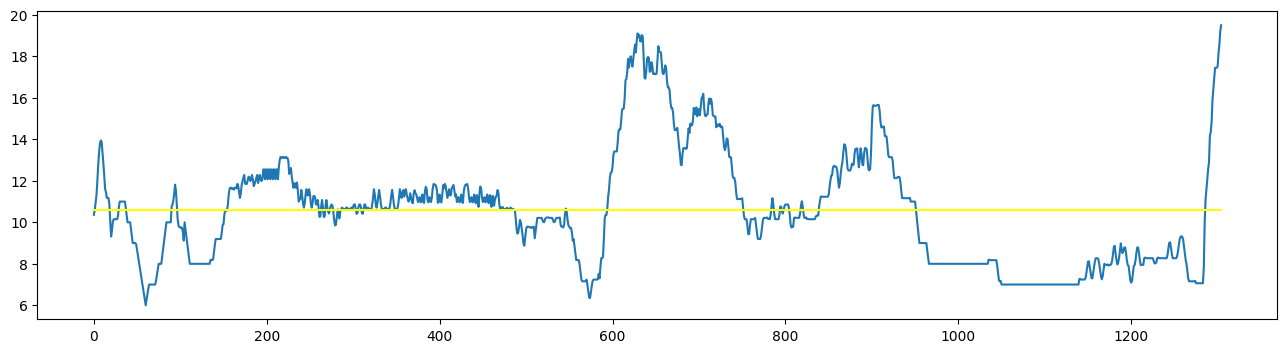

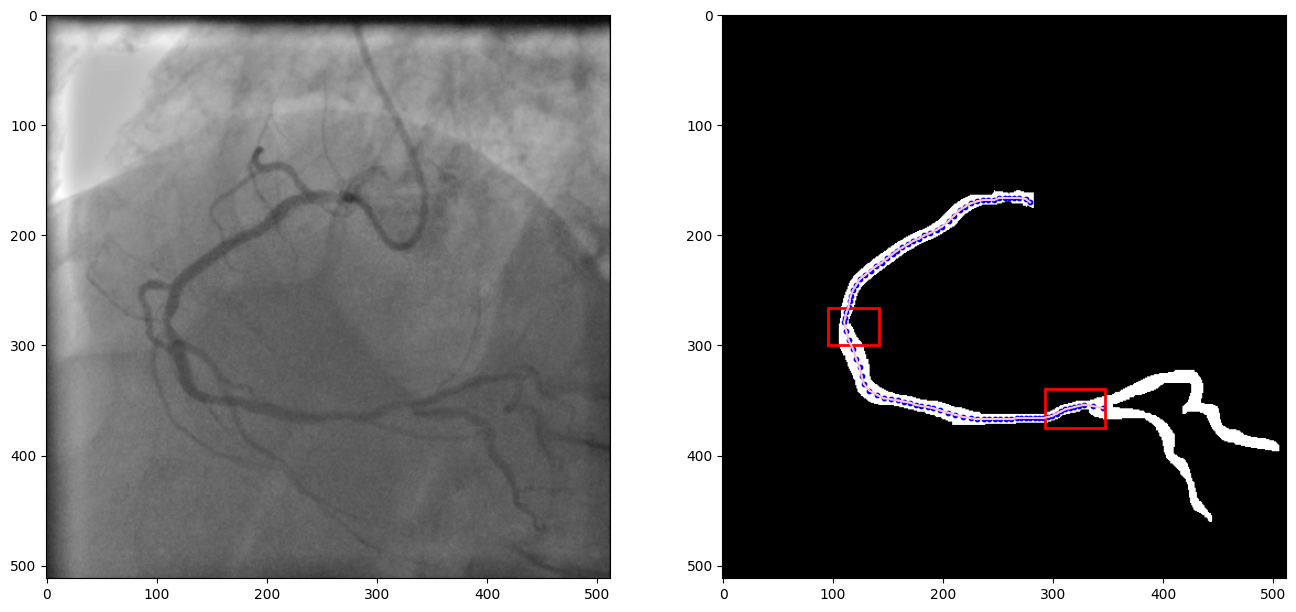

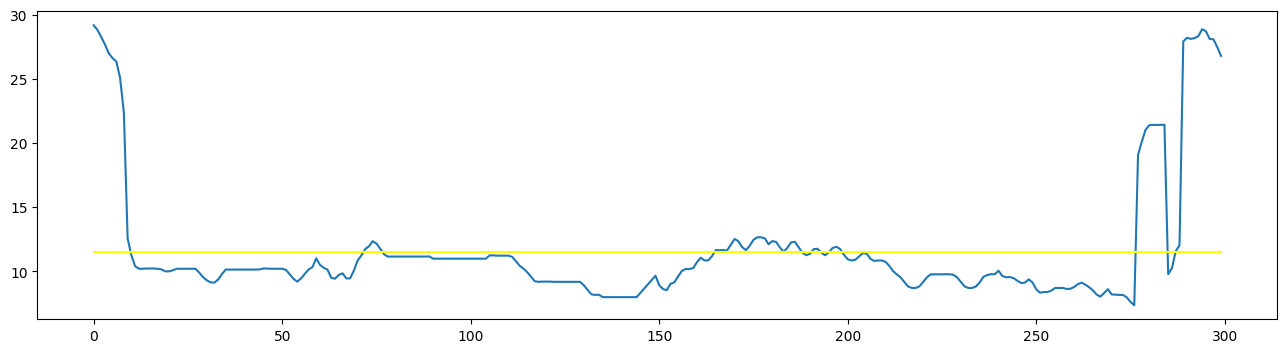

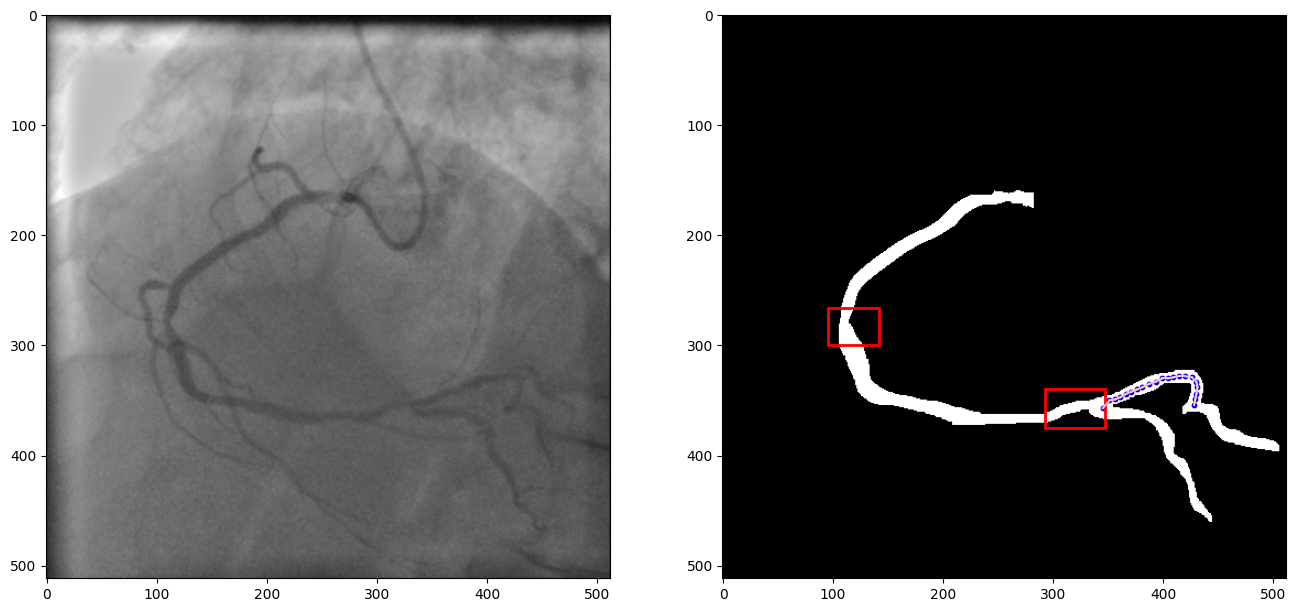

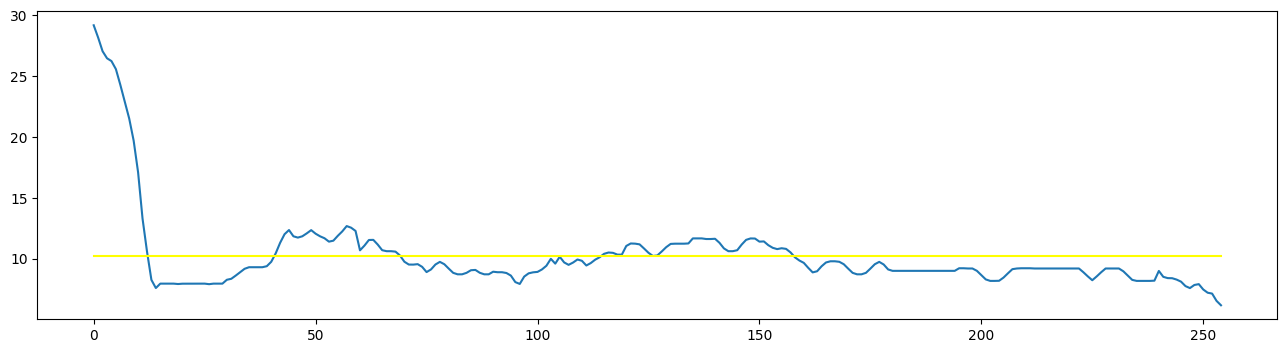

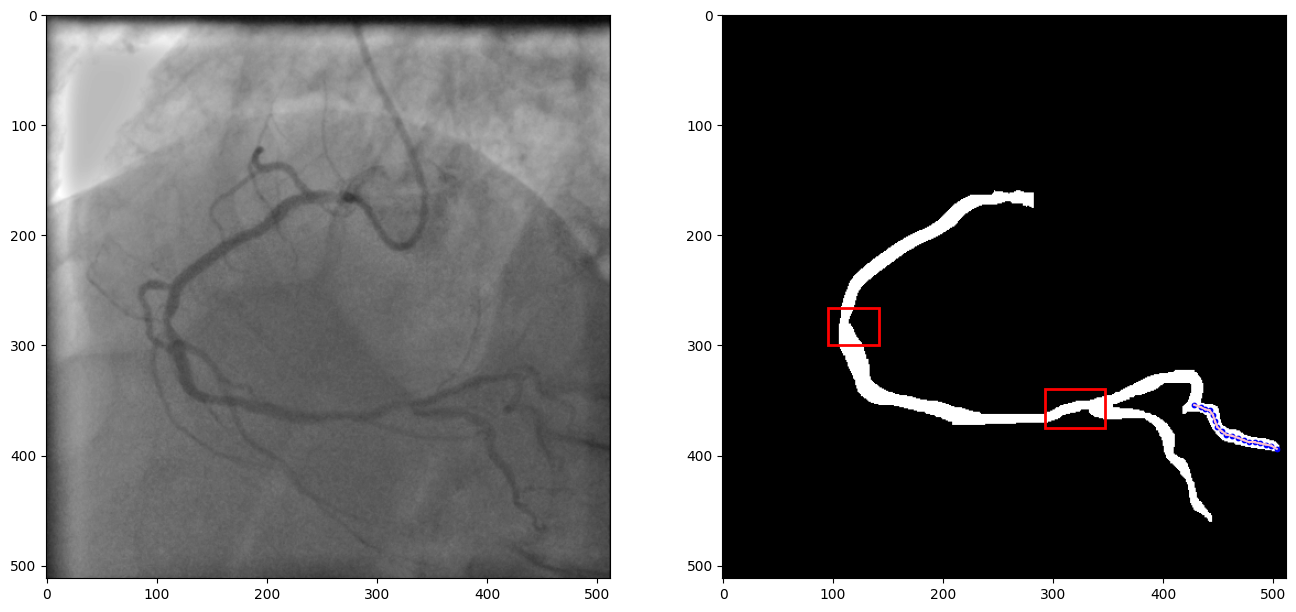

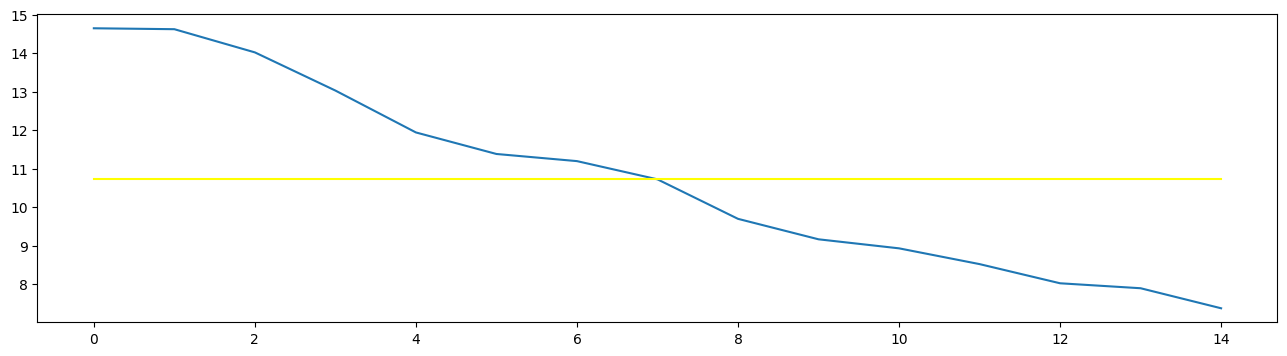

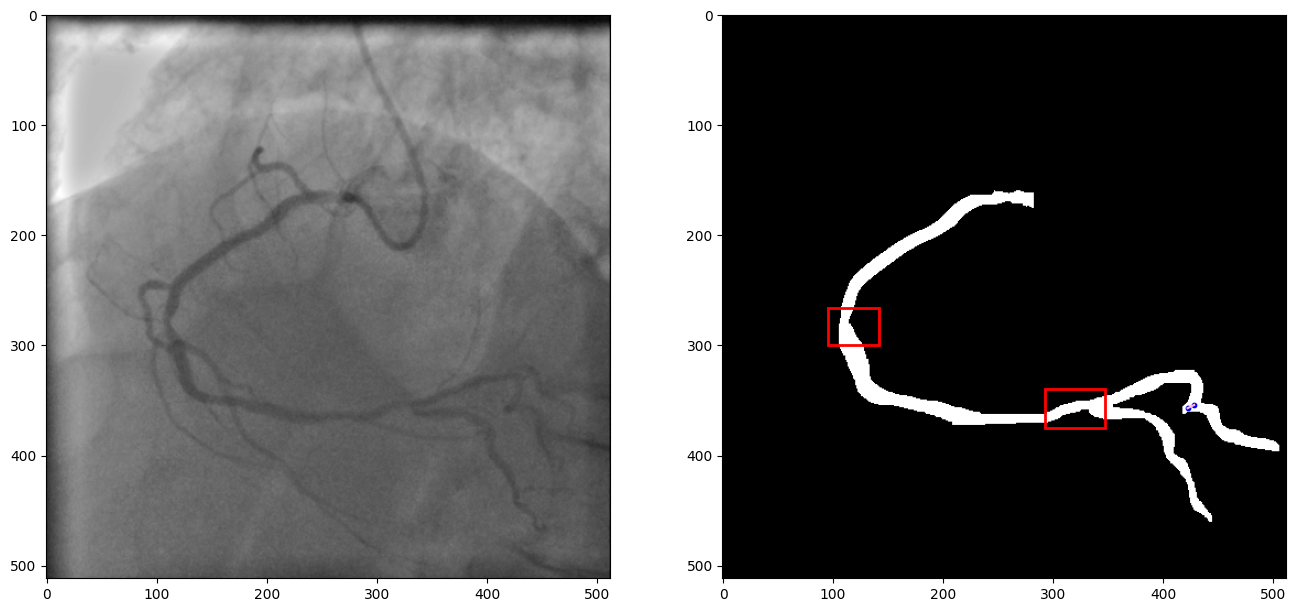

In [203]:
plot_analysis(dataset[28])

### Algorithm (unraveling the original image along the centerline)

In [212]:
def unravel_branch(branch: VesselBranch, width: int = 50, sampling_rate: int = 15) -> npt.NDArray[np.float32]:
        
    def get_orthonormal_vector_2d(v: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        ov = np.array([v[1], -v[0]], dtype=v.dtype)
        return ov / np.linalg.norm(ov)

    def image_along_vector(anchor: npt.NDArray[np.float32], unit_vector: npt.NDArray[np.float32]) -> np.float32:
        steps = width // 2
        pixels = [interpolate_matrix(branch.item.scan, anchor[0], anchor[1])]

        # going backward
        pos = np.copy(anchor)
        for _ in range(steps):
            pos -= unit_vector
            value = interpolate_matrix(branch.item.scan, pos[0], pos[1])
            pixels.append(value)
        
        pixels = pixels[::-1]
        
        # going forward
        pos = np.copy(anchor)
        for _ in range(steps):
            pos += unit_vector
            value = interpolate_matrix(branch.item.scan, pos[0], pos[1])
            pixels.append(value)

        return pixels


    vertical_images = []
    for v, w in branch.traverse_branch_edges():
        v = np.array(v, dtype=np.float32)
        w = np.array(w, dtype=np.float32)

        # FIXME does that create inconsistencies on the node changes? can we fix them by better sampling rate?
        vessel_direction = (w - v) / np.linalg.norm(w - v)
        orthonormal_vector = get_orthonormal_vector_2d(vessel_direction)

        for i in range(int(np.linalg.norm(w - v)) + 1):
            anchor = v + i * vessel_direction

#         vessel_direction = w - v
#         orthonormal_vector = get_orthonormal_vector_2d(vessel_direction)

#         for i in range(sampling_rate):
#             anchor = v + (vessel_direction * i) / sampling_rate

            image = image_along_vector(anchor, orthonormal_vector)
            vertical_images.append(image)

    return np.array(vertical_images)

In [213]:
def plot_unraveled(image: npt.NDArray[np.float32]):
    plt.figure(figsize=(16, 4))
    plt.imshow(image, cmap='gray')
    plt.show()

In [214]:
# TODO develop this for the better analysis
def plot_analysis(item: CoronagraphyScanItem):
    branches = split_into_branches(item)
    for branch in branches:
        widths = width_sweep(branch, sampling_rate=15)
        plot_widths(widths)
        
        unraveled = unravel_branch(branch)
        plot_unraveled(unraveled.T)
        
        branch.plot()

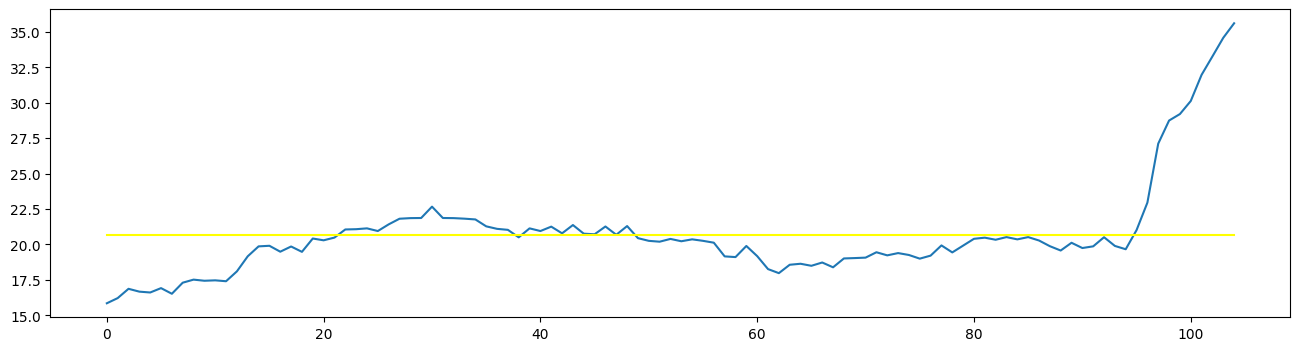

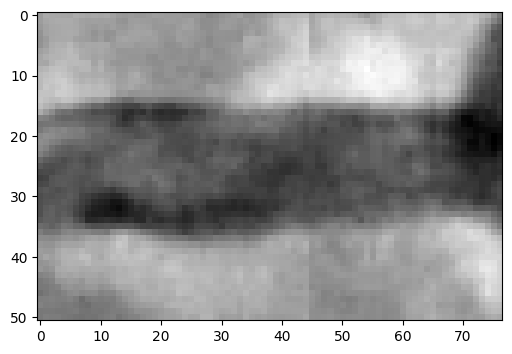

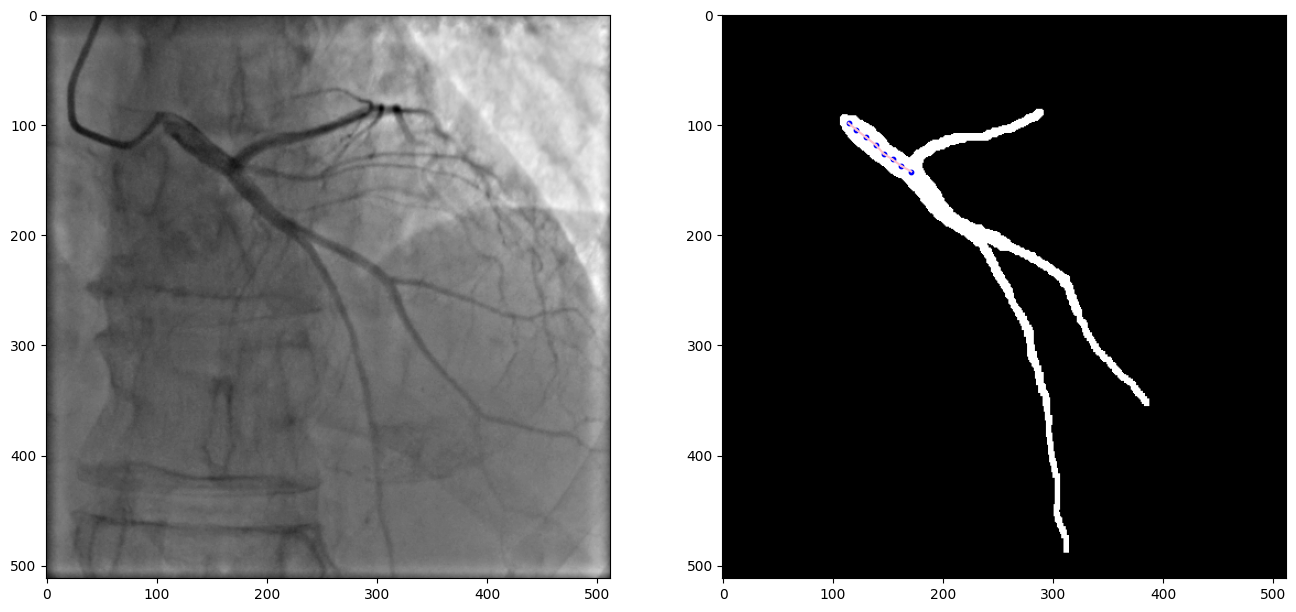

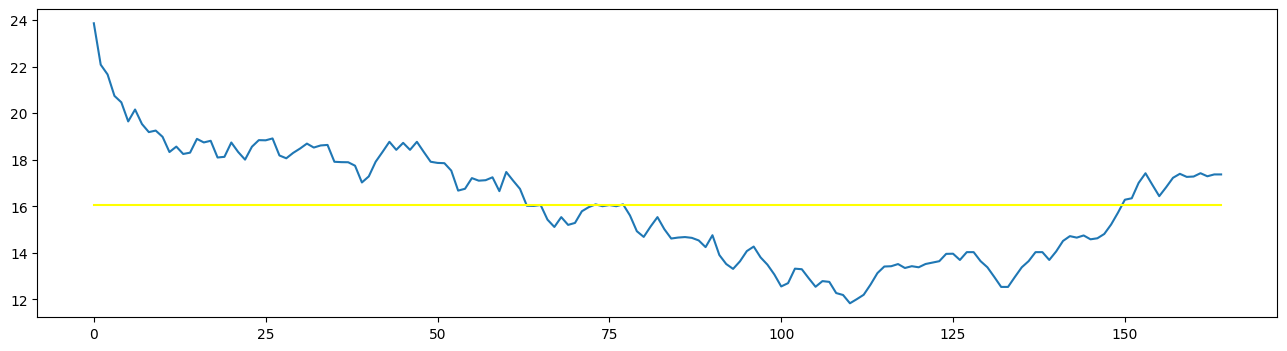

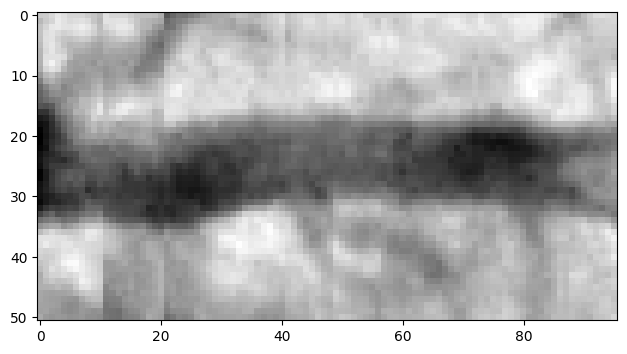

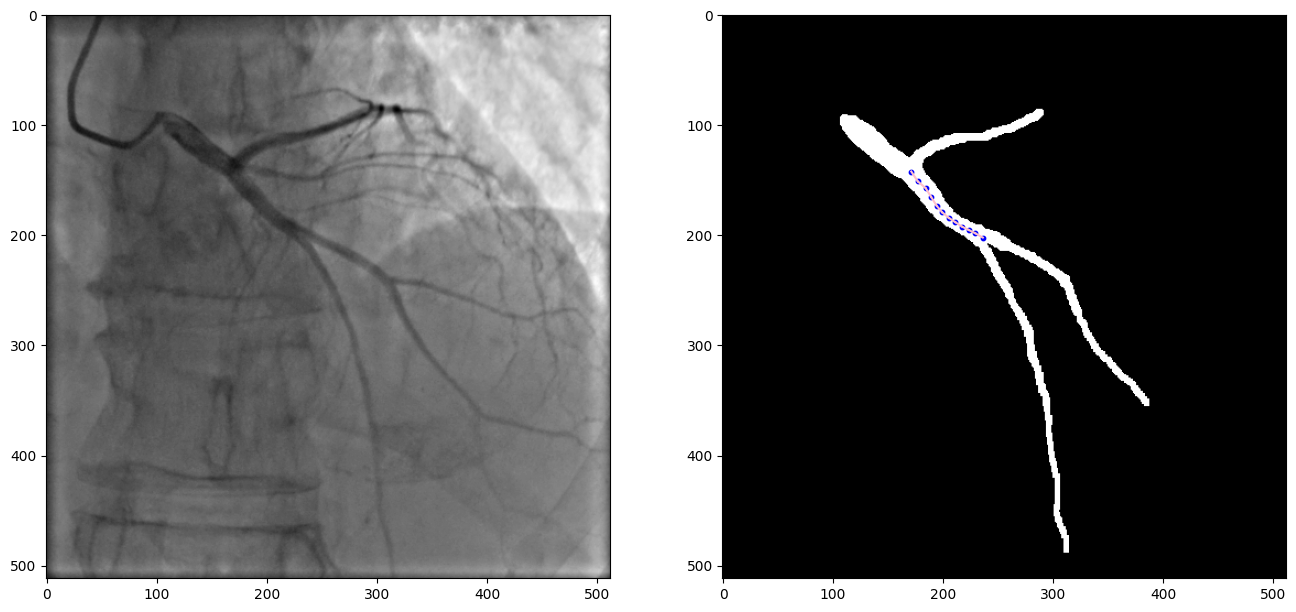

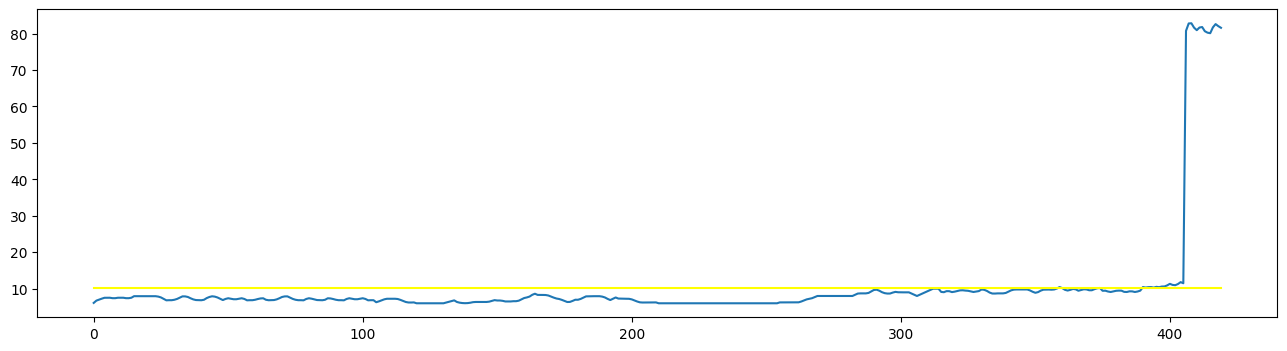

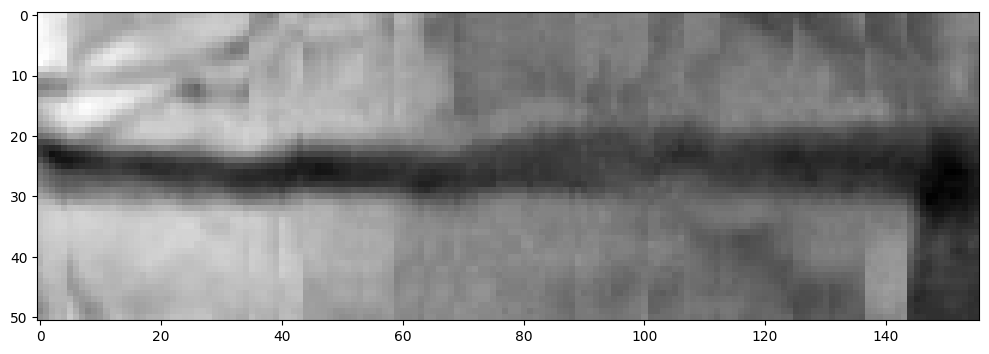

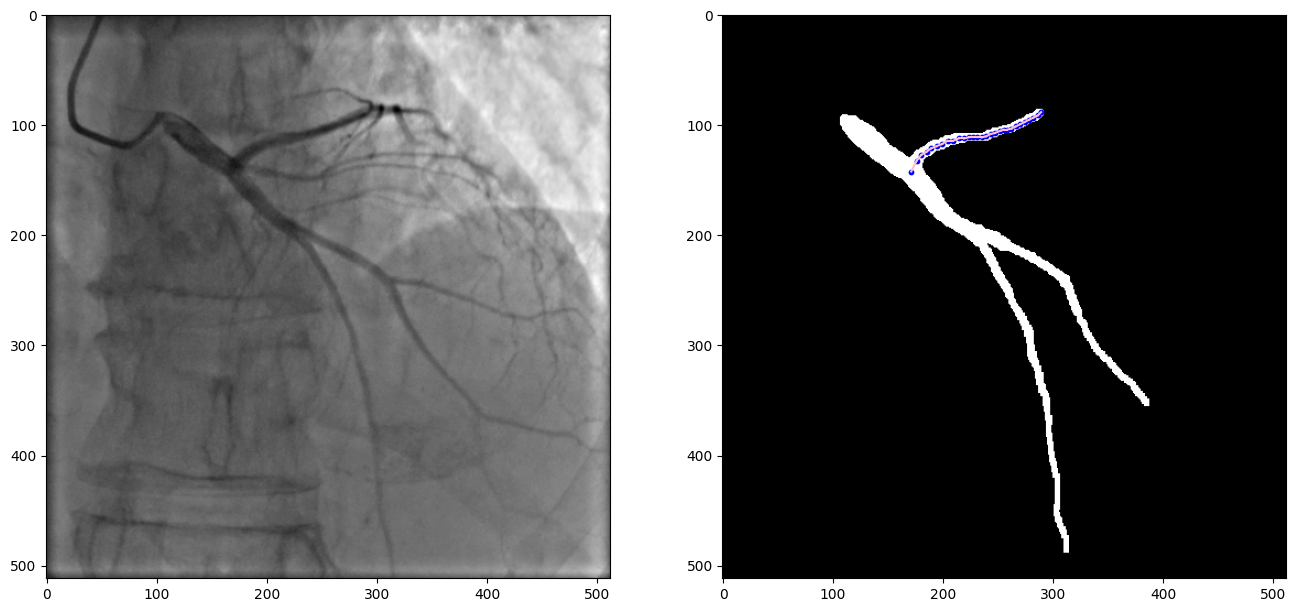

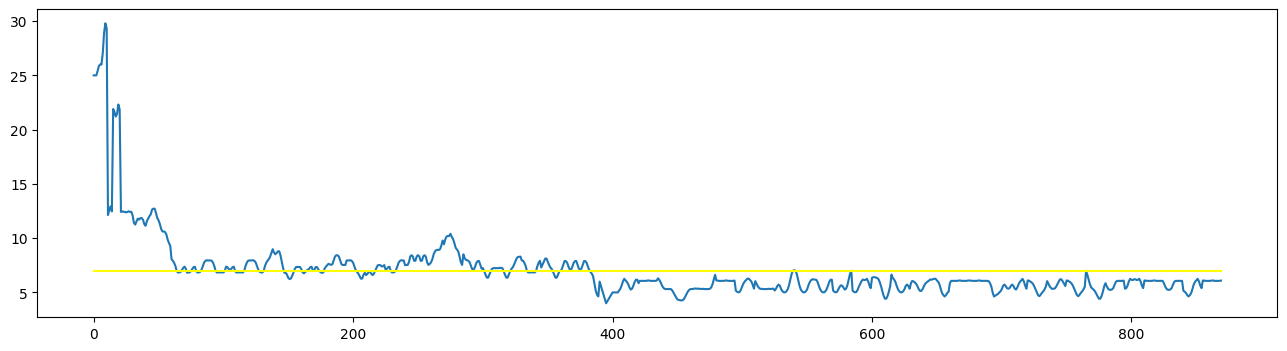

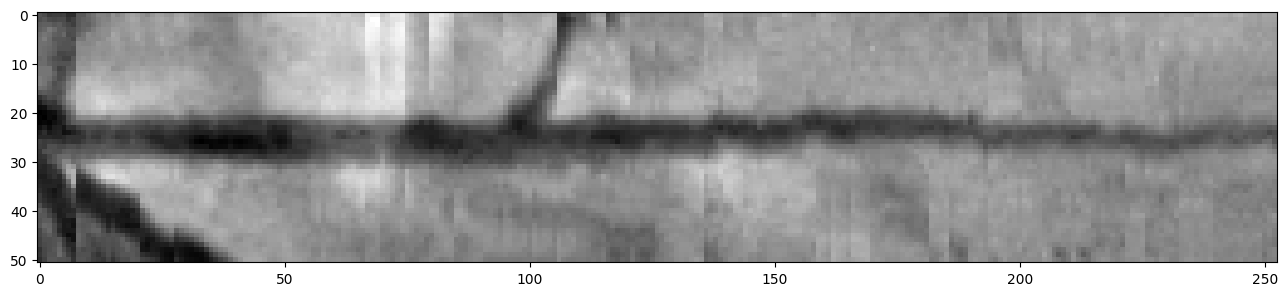

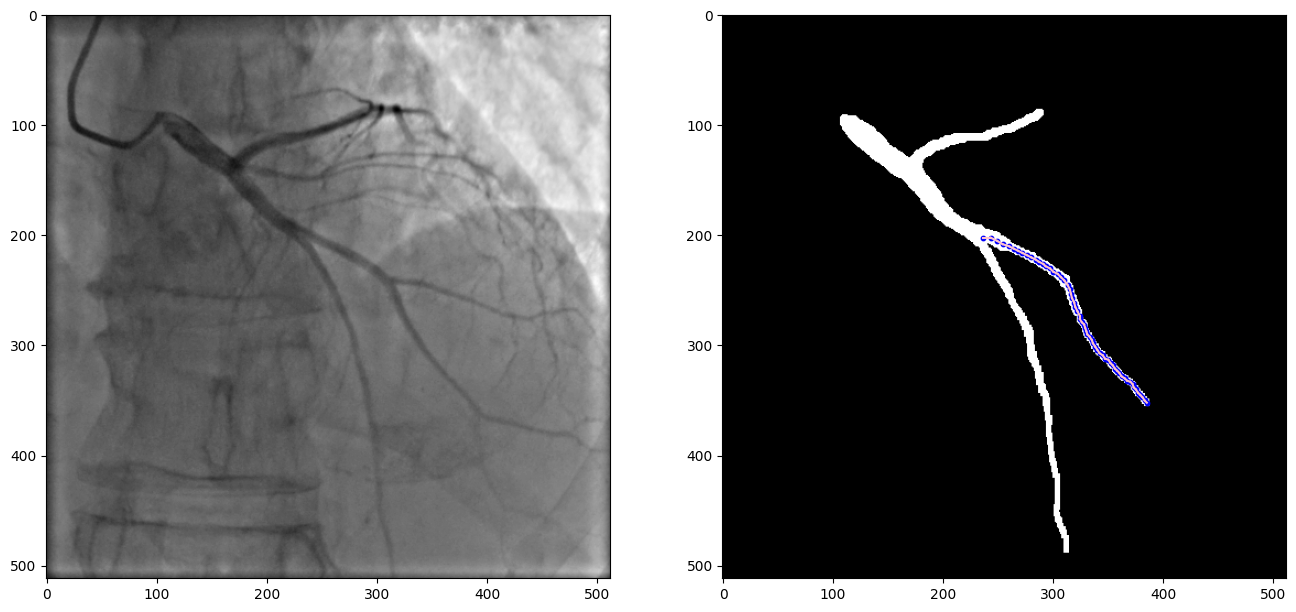

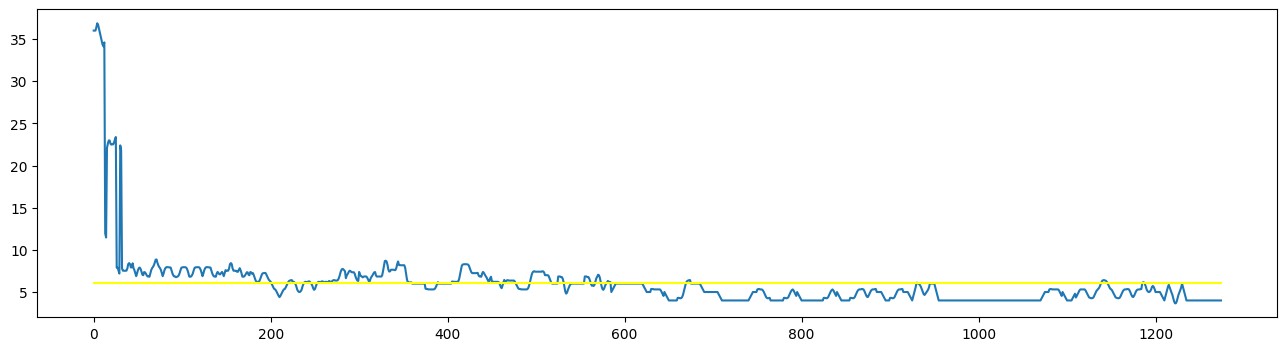

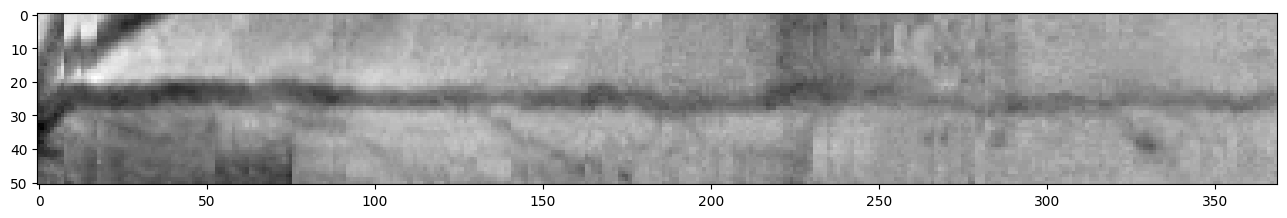

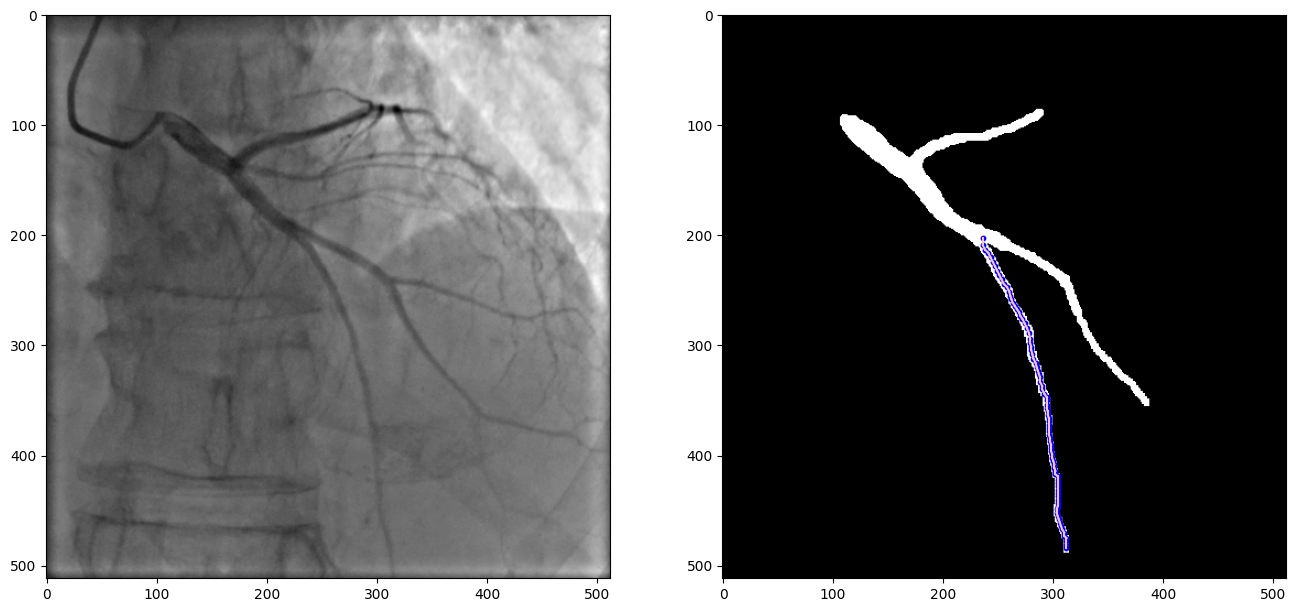

In [215]:
plot_analysis(item)

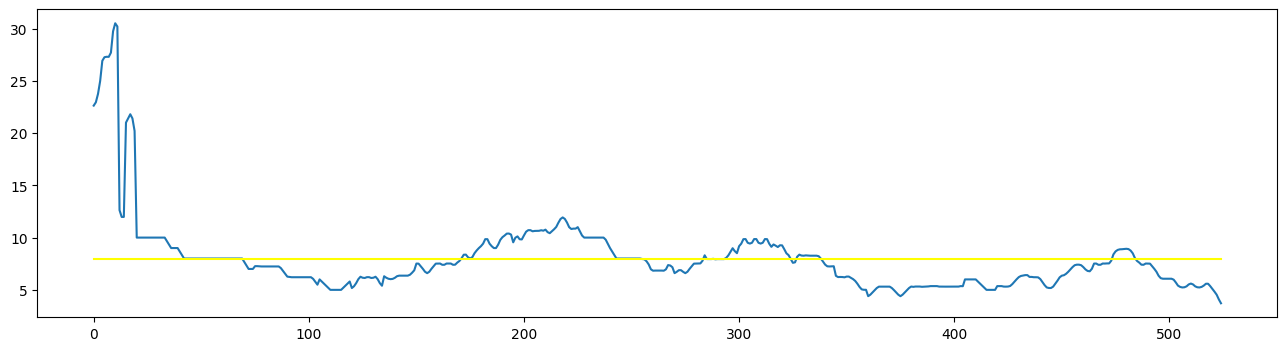

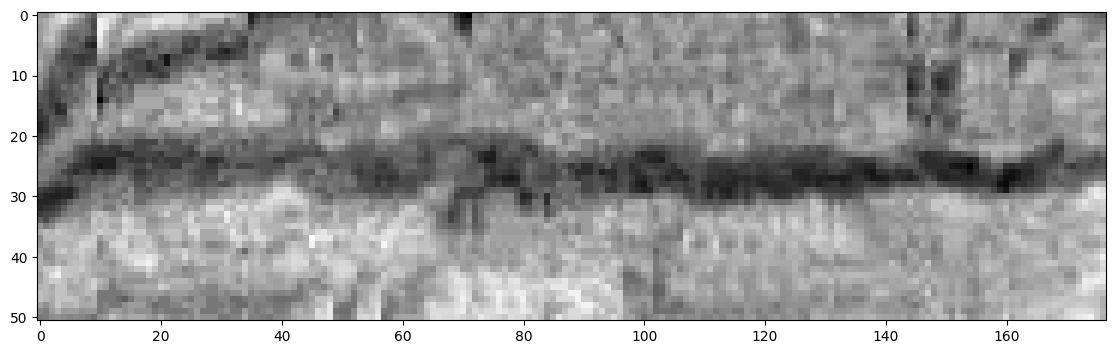

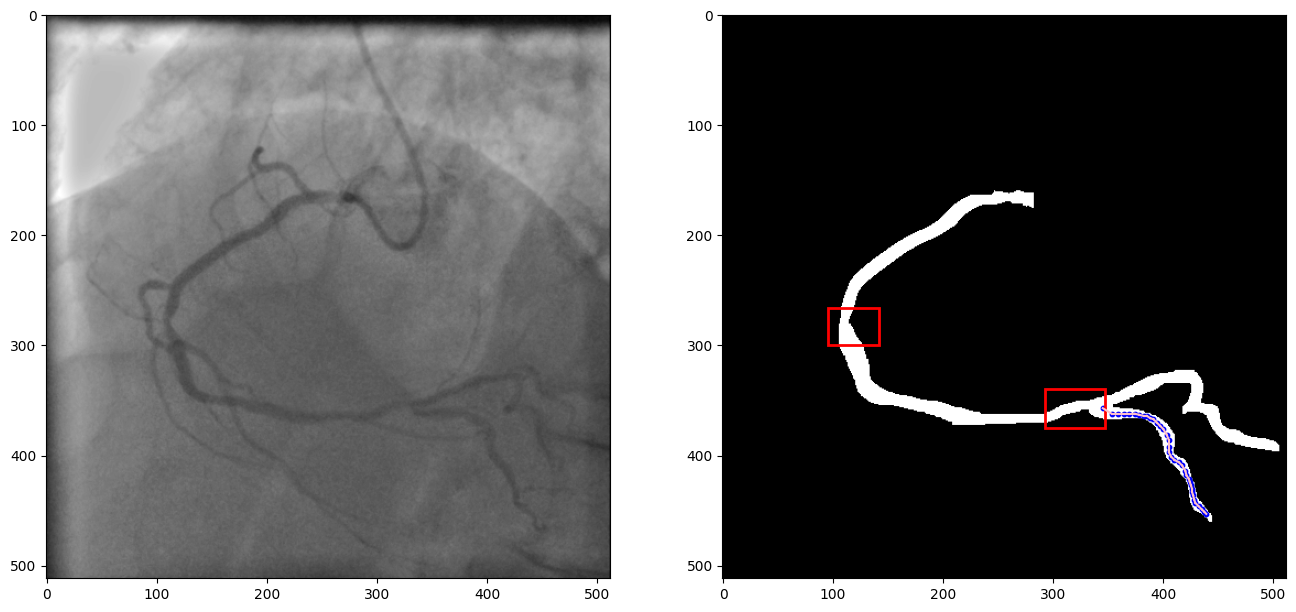

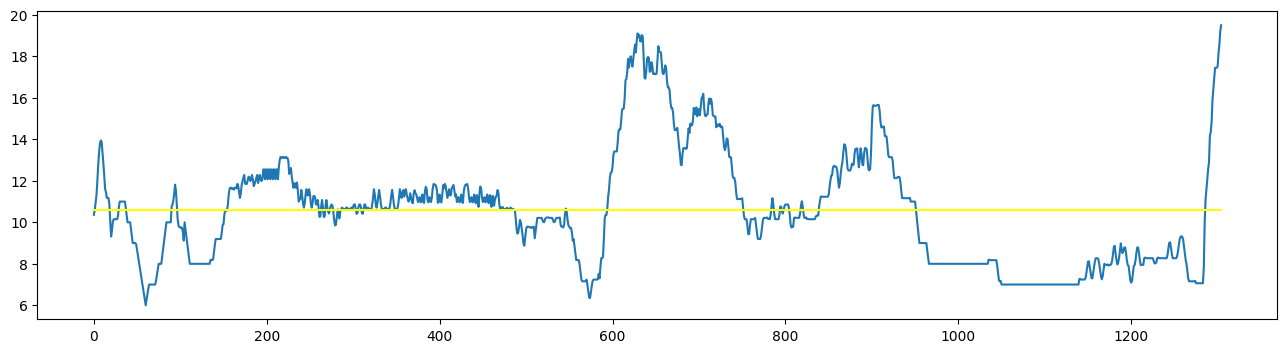

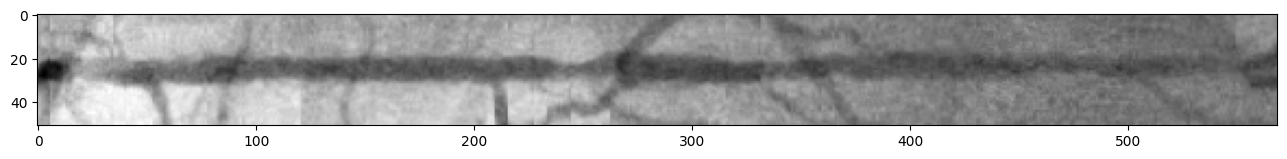

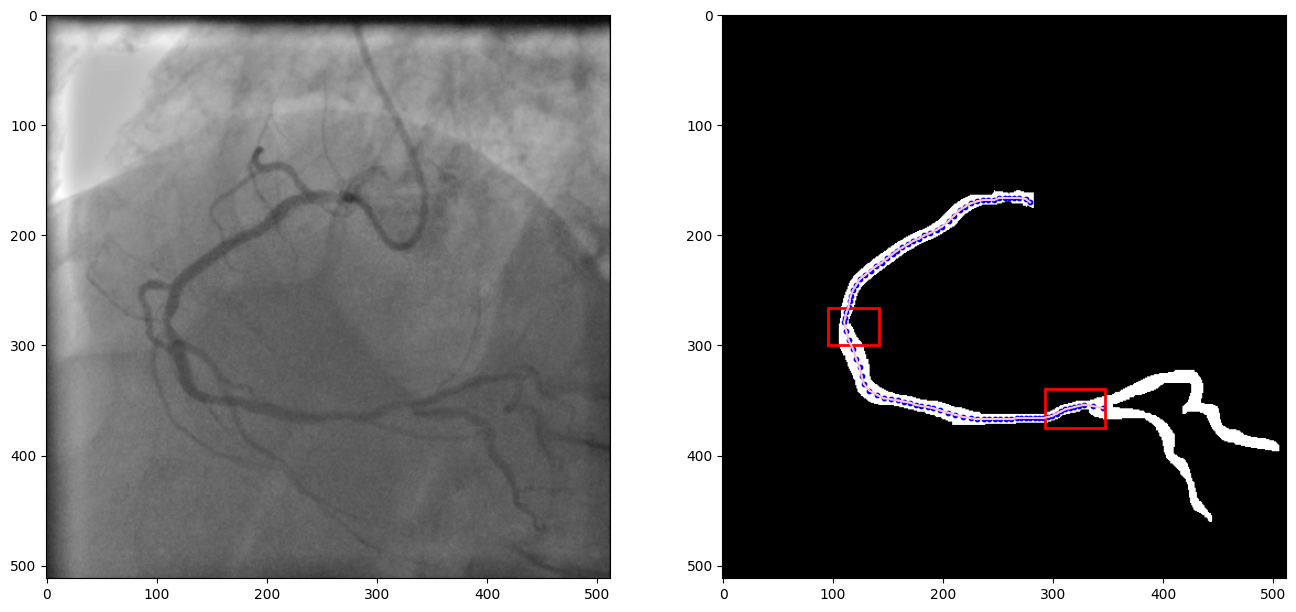

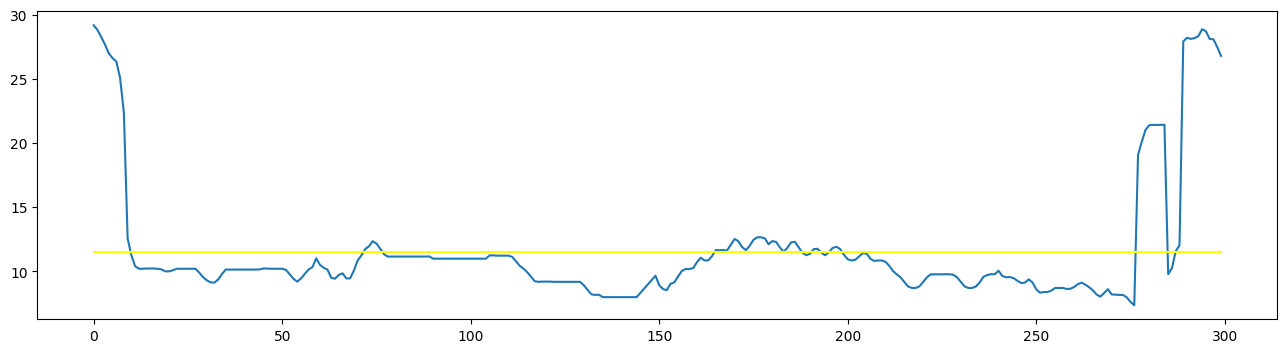

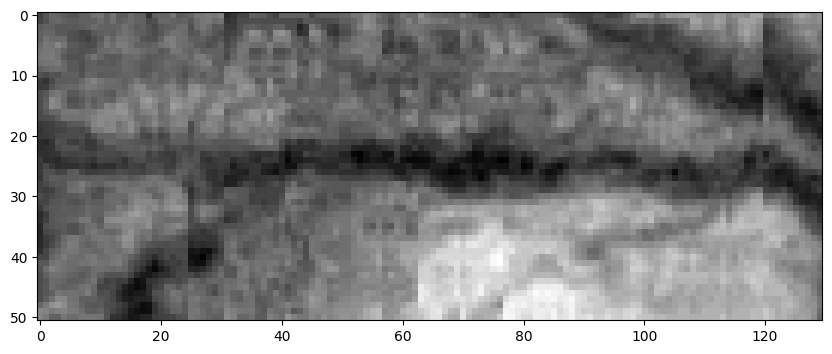

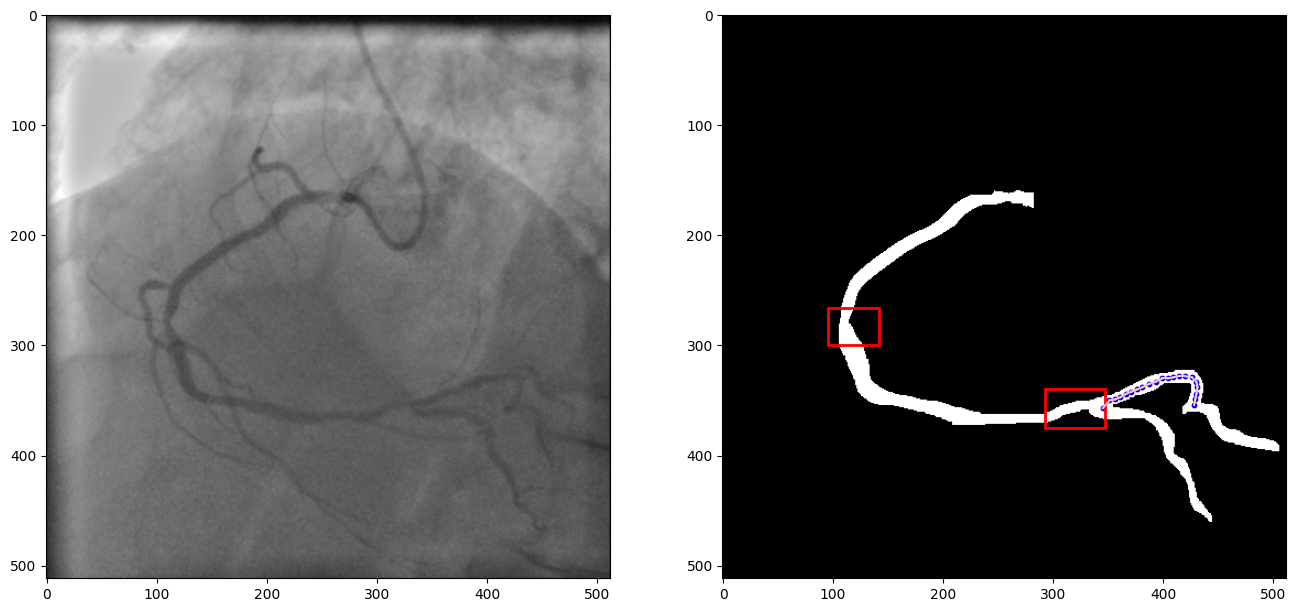

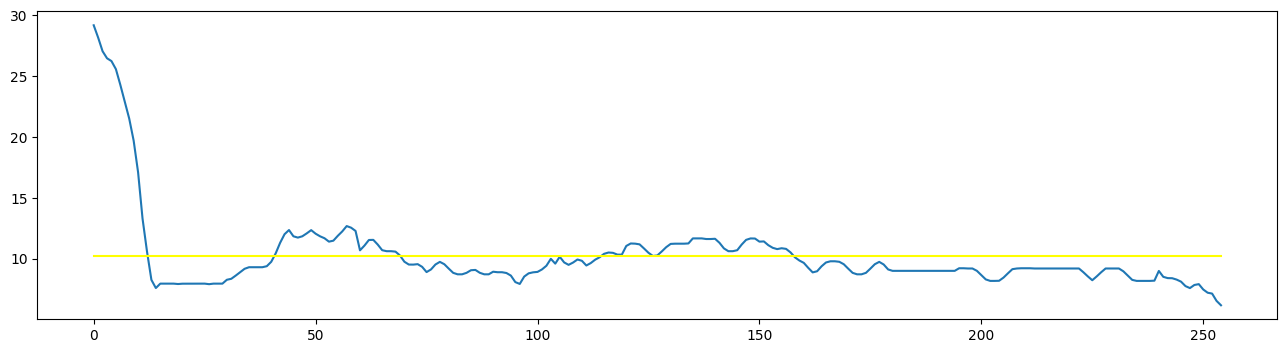

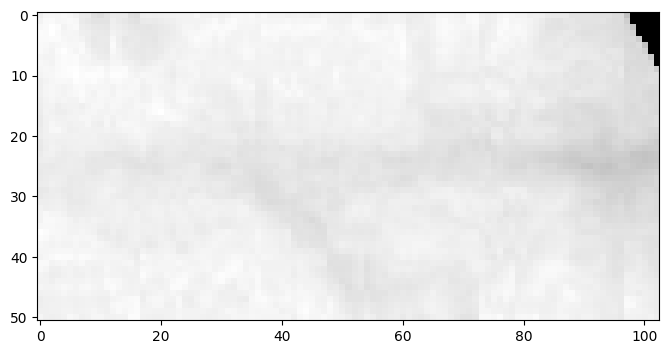

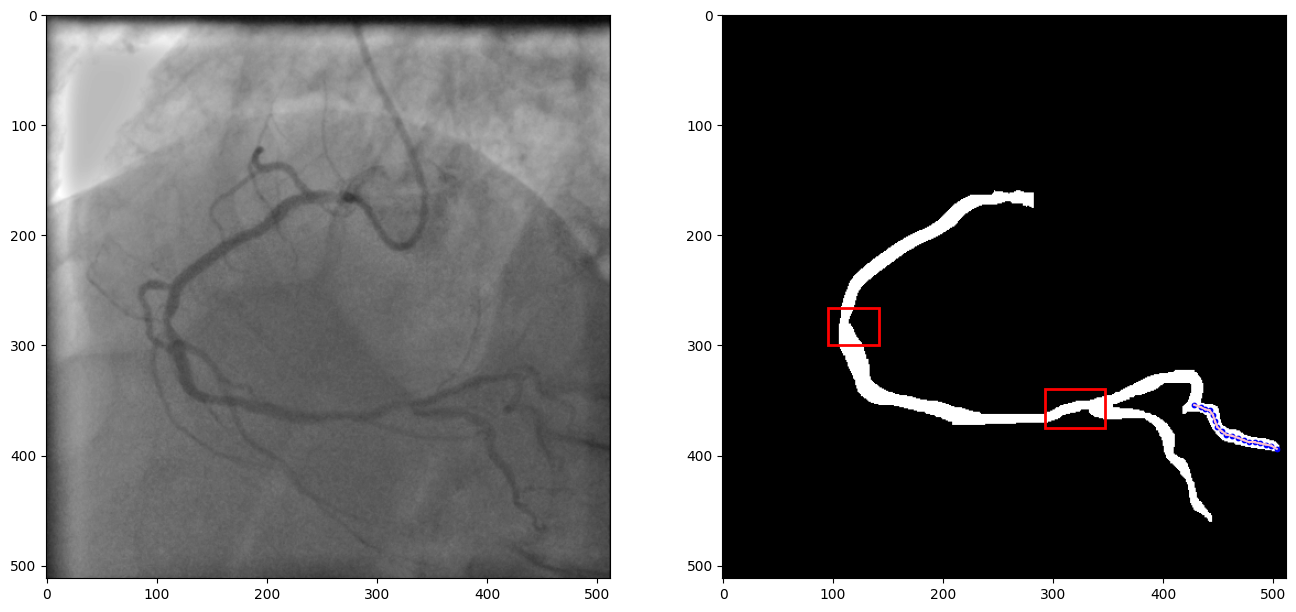

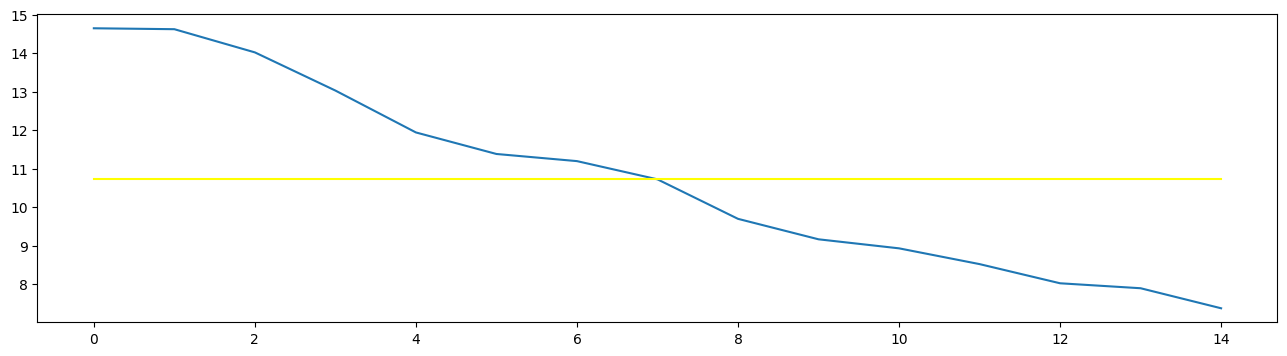

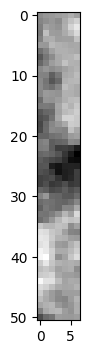

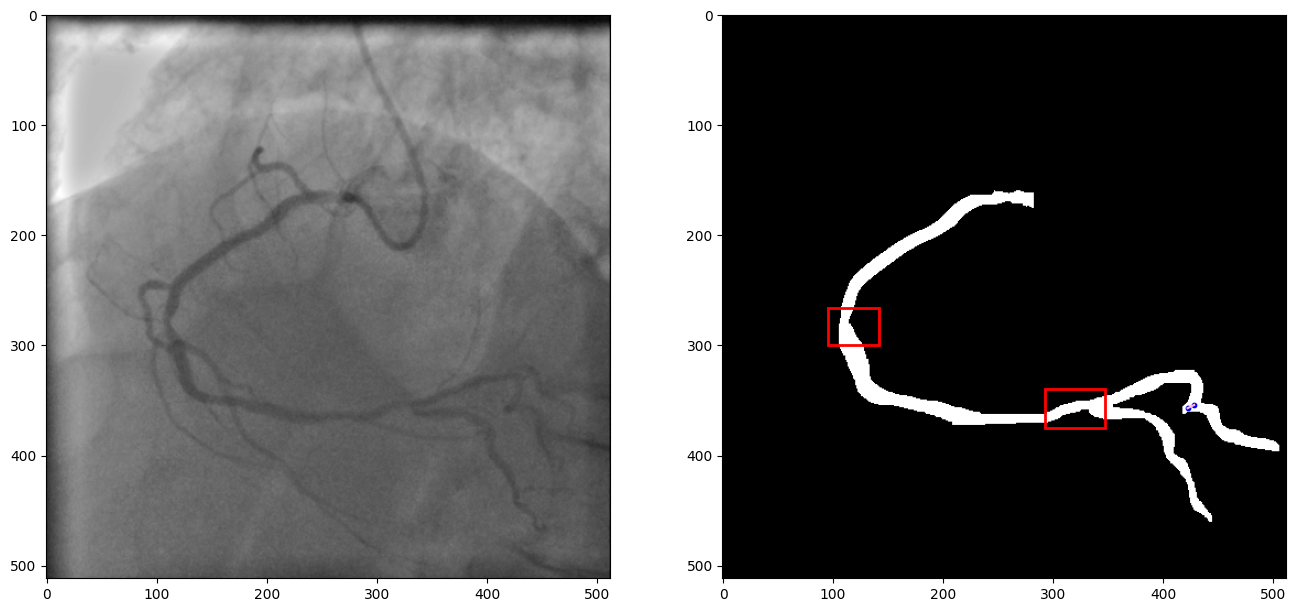

In [216]:
plot_analysis(dataset[28])